## Generative Architecture

In this example, we will model the expectation directly through a generative model. The generative model specifies the distribution of the spectral measure. 

#### Pickands Function as an Expectation
Remember that we can write $$A(s_1, \ldots, s_d) = \mathbb{E}_{w \sim \Lambda}\left[\max_{j=1\ldots d} s_i w_i \right ].$$
In this scenario, we want to represent $\Lambda$ through a generative network so $\Lambda \approx g_\theta$. We can use a basic MLP to model the generator. 

We will use the same parameter estimation scheme from the previous notebook:

#### Parameter Estimation
Since differentiating the full CDF is highly prone to numerical errors, we consider a particular property of extreme value distributions. 
Let $M$ be a sample of componentwise maximum and let $\tilde{M}_j = -\log F_j (M_j)$ be the log of the margin transformed maximum. 
Define the random variable $Z_w$ as
$$
Z_w = \bigwedge_{j=1\ldots d} \tilde{M}_j/w_j, \quad w \in \Delta_{d-1}. 
$$
Then $Z_w \sim \text{Exp}(A(w))$. 
This transformation allows us to use the maximum likelihood estimate for a 1-dimensional random variable for the full d-dimesional vector by sampling along the simplex $\Delta_{d-1}$. 


We'll begin by importing the necessary packages. 


In [1]:
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, random_split

from pytorch_lightning import Trainer, seed_everything

from datasets import ASL, SL
from gen import GenerativePickandsModule
from nets import SMLP
from utils import CFGEstimator, rand_simplex

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Now let's define the dataset. We will use a 2D symmetric logistic distribution. 

In [2]:
d = 2
n_data = 100
alpha = 0.5

dataset = SL(d, n_data, alpha)
dataset_test = SL(d, n_data, alpha)

def pickands_sl(w, alpha=alpha):
    if alpha == 0:
        return w.max(1)[0]
    return torch.sum(w ** (1 / alpha), dim=1) ** alpha

train_loader = DataLoader(dataset, batch_size=n_data, shuffle=False)
test_loader  = DataLoader(dataset_test, batch_size=n_data, shuffle=False)

Now let's define the training routine. This also uses Pytorch Lightning. This time we will fit a basic MLP to the generator. 

In [3]:
%%capture --no-display

latent_size = 4

# Trainer parameters
trainer_params = {
        'gpus' : 0,
        'max_epochs' : 100
        }

# Conditional Pickands Module Parameters
model_params = {
        'pickands' : pickands_sl,
        'lr' : 1e-3,
        'latent_size' : latent_size,
        'd' : d,
        'use_swa' : False,
        'cov' : None
        }

# MLP Parameters
arch_params = {
        'input_size' : latent_size, # latent size for generative model
        'layers' : 2,  
        'hidden_size' : 256,
        'out_size' : d
        }

net = SMLP(**arch_params)
gpm = GenerativePickandsModule(net=net, **model_params)
trainer = Trainer(**trainer_params)

trainer.fit(gpm, train_loader, test_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type | Params
------------------------------
0 | net  | SMLP | 134 K 
------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.540     Total estimated model params size (MB)


Finally, let's plot a comparison of the true pickands function, the CFG pickands function using real data, and the CFG pickands function using simulated data. We can repeat this experiment for higher dimensional data, but we will have to compute the MSE between the estimated and true Pickands functions.

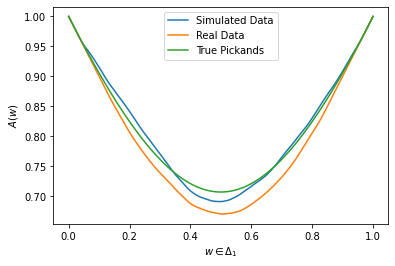

In [4]:
samples = gpm.sample(100)

cfg_gen  = CFGEstimator(torch.Tensor(samples[0]))
cfg_true = CFGEstimator(torch.Tensor(dataset[:100][0]))

X_ = torch.linspace(0,1,100)
X  = torch.stack((X_,1-X_),1)

plt.plot(X_, cfg_gen(X), label='Simulated Data')
plt.plot(X_, cfg_true(X), label='Real Data')
plt.plot(X_, pickands_sl(X), label='True Pickands')
plt.xlabel(r'$w \in \Delta_1$')
plt.ylabel(r'$A(w)$')
plt.legend()
plt.show()